# Quantum Kernel Estimate SVC algorithm

Quantum computer can be employed to embed classical data into the quantum (potentially infinite) Hilbert space. 
Having created two quantum states parametrized with the classical data, the quantum computer can inherently estimate the quantum state fidelity and associate it with the quantum kernel matrix element.
Computed in this way the kernel matrix can be further used in any kernel based machine learning algorithm, e. g., in the Support Vector Machine (SVM).
This version of the hybrid Quantum Kernel + SVM approach received the name the Quantum Kernel Estimate (QKE) [1].
In this tutorial, we apply QKE to classify a simple synthetic dataset.

[1] Havlicek, V.; Córcoles, A. D.; Temme, K.; Harrow, A. W.; Kandala, A.; Chow, J. M.; Gambetta, J. M. Supervised Learning with Quantum Enhanced Feature Spaces. Nature 2019, 567 (7747), 209–212. https://doi.org/10.1038/s41586-019-0980-2.

In [1]:
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from qksvm.QKSVC import QKSVC
from sklearn import metrics

from common import generate_moons_dataset
from common import visualize_decision_boundaries
from common import print_scores

seed = 12345

# Dataset

The [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) is chosen for the demonstration purposes.
This dataset has non-trivial and non-linear decision boundaries such that no separating hyperplane could be found to perfectly split 2 data classes.

Following the standard machine learning (ML) practice, we generate 2 independent datasets. The first dataset (`X_train`=($x_1$, $x_2$) - the 2d cartesian coordinates, and `y_train`={0, 1} - the datapoint labels) is used for training the chosen model and optimizing the model hyperparameters.
The second dataset `(X_test, y_test)` serves to crosscheck the accuracy of the model on previously unseen datapoints (thus testing the model generalization performance).

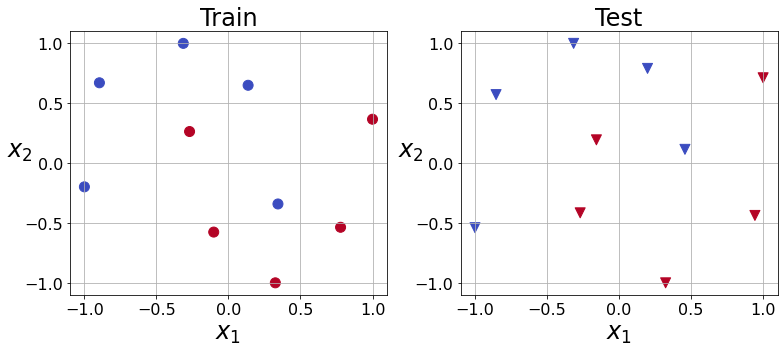

(10, 2)
(10, 2)


In [2]:
X_train, y_train, X_test, y_test = generate_moons_dataset()
print(X_train.shape)
print(X_test.shape)

# Quantum Feature Map

Embedding classical data into the quantum states with a quantum computer provides a powerful and flexible way to extract the similarity measure (kernel matrix) that serves as an input for multiple machine learning techniques.

Technically speaking, following the gate-based approach to the quantum computing, everything what what we need to do to setup a quantum kernel is to specify a quantum circuit. This quantum circuit must clearly contain gates that parameterically depend on the input datapoints (i. e., encode the input information). Moreover, the circuit could consist of any sort of other data independent single- and multi-qubit gates. 
There are no specific instructions how to setup such circuits in the most efficient way - currently, it is an intensive field of research.

The most straightforward and popular QML encoding approach uses the "single feature per qubit" strategy with the single qubit rotation Pauli gates accepting the data point coordinates as parameters.
In this approach, to be able uniquely encode, the data should be preprocessed (rescaled) to fall into the periodicity interval of the rotational gates [0, 2$\pi$]. (As a notice, this preprocessing is already applied in the `generate_moons_dataset()` such that the datapoint coordinates are between -1 and 1).

As an exercise, below we show a few generic ways how a user may setup a quantum feature map (quntum encoding circuit).

## Qiskit feature map generators

Following the original publication by [Havlicek et al. (2019)](https://www.nature.com/articles/s41586-019-0980-2), Qiskit provides a quantum feature map generator for QML purposes.

In [3]:
from qiskit.circuit.library import PauliFeatureMap

n_features = len(X_train[0])
n_layers = 1

fm = PauliFeatureMap(n_features, alpha=2.0, reps=n_layers, paulis=['Z'])
print(fm.decompose().draw(plot_barriers=False, fold=150))

     ┌───┐┌─────────────┐
q_0: ┤ H ├┤ P(2.0*x[0]) ├
     ├───┤├─────────────┤
q_1: ┤ H ├┤ P(2.0*x[1]) ├
     └───┘└─────────────┘


## Extended and generalized quantum feature map generator

The Qiskit `PauliFeatureMap` implements a rather restricted sub-class of the possible embeddings.
An extended version of the Pauli rotation based embedding is provided in the `QKSVM` library.
The `QuantumFeatureMap` encoding circuit generator implements a big portion of the quantum embedding strategies discussed in the quantum kernel ML literature.
In the generator, we use a common convention to encode all data features with the same sequence of gates specified by `gates`.
Current version supports only single and 2-qubit quantum gates given in the Qiskit notation. In the example below, 'H' is the Hadamard gate and 'RZ' is the Pauli Z-rotation operator (i. e., RZ=$\exp\left(-i\frac{\theta}{2}\sigma_z\right)$, where $\theta$ is the rotation angle).
For the reason you will learn in the tutorial about the Quantum Kernel Training, the parametric gates should be specified in the upper case.

In [4]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    alpha=2.0,
    gates=['H', 'RZ'],
    entanglement='linear'
)
print(fm.draw(plot_barriers=False, fold=150))

     ┌───┐ ┌──────────────┐ 
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├─
     ├───┤ ├──────────────┤ 
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─
     └───┘ └──────────────┘ 


## Generic (manual) quantum feature map setup

The most general approach to create a feature map circuit (especially for the embeddings that are not included into the shown above generators) would be to use the standard Qiskit circuit setup procedure.

In [5]:
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter

n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

fm = QuantumCircuit(n_qubits)

x = ParameterVector("x", length=n_features)
fm.alpha = Parameter("α")

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(fm.alpha * x[j % n_features], i)
        j += 1
    fm.barrier()

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)
print(fm.draw(plot_barriers=False, fold=150))

     ┌───┐┌──────────────┐ 
q_0: ┤ H ├┤ Rz(2.0*x[0]) ├─
     ├───┤├──────────────┤ 
q_1: ┤ H ├┤ Rz(2.0*x[1]) ├─
     └───┘└──────────────┘ 


# QKE SVC

As we could see, to setup a quantum feature map we need to provide the following information:

* number of qubits;
* list of the data encodding quantum gates;
* the encoding gate pattern can be repeated such that the same features could enter the circuit multiple times (repeated encoding scheme). The easiest way to realize it is to repeat the encoding sub-circuit multiple times, i. e., building the encoding layers.
* for 2 and more qubit operators, one should specify the inter qubit connectivity. Moreover, the connectivity could be predefined by the quantum hardware architecture.

Since all these circuit parameters determine the quantum kernel, we include them into the list of the QML hyperparameters.

`QKSVC` class provides an extension of the Scikit-Learn SVC class to support the quantum kernels originated with the encoding feature map circuit.
As an input, the `QKSVC` classifier accepts the following hyperparameters:
* Feature map given either symbolically or as a quantum circuit;
* In case the feature map specified symbolically, 4 additional (circuit generator related) parameters should be included:
  1) number of qubits;
  2) number of layers;
  3) feature scaling prefactor $\alpha$;
  4) 2-qubit gate entanglement map.
* same as in the classical case, `C` corresponds to the SVM regularization strength.

Similar to the parameter $\gamma$ in the case of the RBF (Gaussian) kernel, the feature scaling prefactor $\alpha$ plays an important role in the setup of the quantum kernels.


Prediction Scores:

		Train	Test
Accuracy:	0.80	0.80
 ROC_AUC:	0.80	0.80



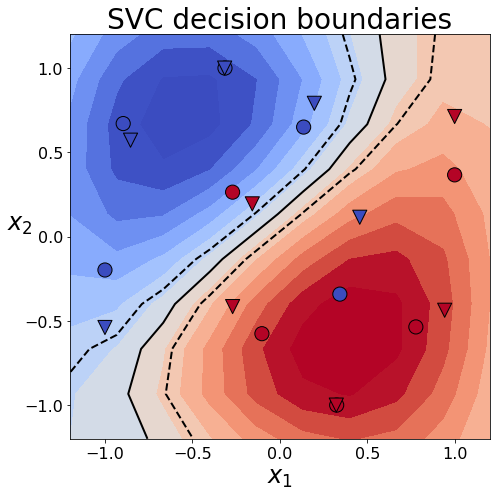

In [6]:
params = {'C': 1, 'alpha': 2.0, 'feature_map': ['H', 'RZ', 'CZ'], 'n_layers': 1, 'n_qubits': 2}

clf = QKSVC(
    C=params['C'],
    alpha=params['alpha'],
    feature_map=params['feature_map'],
    n_layers=params['n_layers'],
    n_qubits=params['n_qubits'],
    entanglement='linear', 
    random_state=seed
)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

The classification scores obtained with QKE are comparable with those from the RBF SVC model. 
Also here the decision boundaries do not really follow the structure of the moons dataset.
But we did not optimize any QKE hyperparameter so far.

# QKE hyperparameter search

As the (parent) SVC class, the QKSVC class can be used in the `GridSearchCV` procedure to find optimal combinations for the quantum kernel hyperparameters.
In the test below, we are going to examine feature maps built of different types of the parametric gates and consisted of the different number of qubits, the number of the repeated encoding layers.
In addition, the specified feature maps will test different types of the entanglement. 
E. g., with `crx` the input data also enters into the controlled-rotation gates enlarging the entanglement operator space.

Best grid search parameters: {'C': 1, 'alpha': 2.0, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}
Best training score: 0.8

Prediction Scores:

		Train	Test
Accuracy:	1.00	1.00
 ROC_AUC:	1.00	1.00



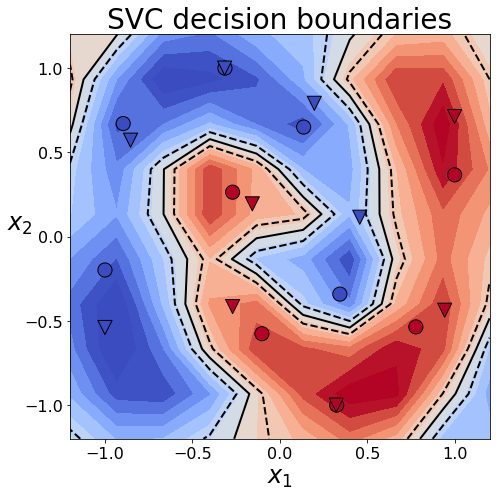

In [7]:
param_grid = {
    "alpha": [1.5, 2.0, 2.5, 3.0],
    "C": [1],
    "n_layers": [1, 2],
    "n_qubits": [2, 3, 4],
    "feature_map": [
                    ['rx', 'cz'], 
                    ['rx', 'cx'], 
                    ['rx', 'swap'],
                    ['rx', 'crx'],
                    ['rx', 'cry'],
                    ['rx', 'crz'],
                    ['rx', 'ry', 'cz'],
                    ['rx', 'ry', 'cx'],
                    ['rx', 'ry', 'swap'],
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)
clf = gs.best_estimator_

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

As a result of the hyperparameter optimization procedure we have found a quantum kernel that results to the maximum training score. The high accuracy score is additionally supported by the decision boundaries plot, where one can clearly see the expected "moon" shapes.

Very often, the grid search leads to multiple optimal or near optimal solutions. Therefore, it is also interesting to inspect them:

In [8]:
idx = np.argsort(gs.cv_results_['mean_test_score'])

print("\nBest solutions:\n")
for i in range(5):
    print(f"rank={abs(-i-1)}, score={gs.cv_results_['mean_test_score'][idx[-i-1]]:.2f}, ", "params = ", gs.cv_results_['params'][idx[-i-1]])


Best solutions:

rank=1, score=0.80,  params =  {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'cz'], 'n_layers': 2, 'n_qubits': 2}
rank=2, score=0.80,  params =  {'C': 1, 'alpha': 2.0, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}
rank=3, score=0.70,  params =  {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'ry', 'cx'], 'n_layers': 2, 'n_qubits': 2}
rank=4, score=0.60,  params =  {'C': 1, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}
rank=5, score=0.60,  params =  {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'cry'], 'n_layers': 2, 'n_qubits': 3}


As we can see, there is another circuit (rank=1 for the reason of sorting logic, the order of the printed ranks can be different from the `GridSearchCV` output) that leads to the same score as the *best* solution: `['RX', 'CZ']`. Let's visualize the corresponding decision function plot.


Prediction Scores:

		Train	Test
Accuracy:	0.90	0.90
 ROC_AUC:	0.90	0.90



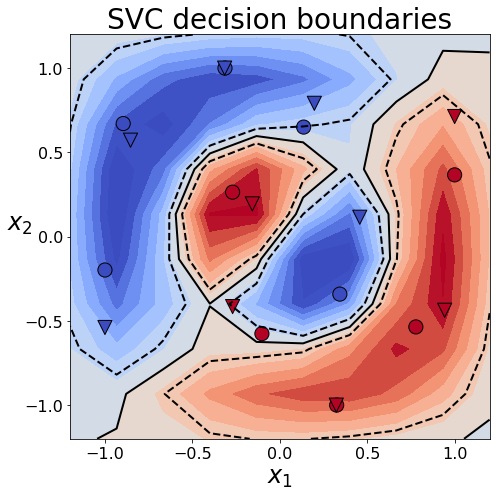

In [9]:
params = {'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'cz'], 'n_layers': 2, 'n_qubits': 2}

clf = QKSVC(
    C=params['C'],
    alpha=params['alpha'],
    feature_map=params['feature_map'],
    n_layers=params['n_layers'],
    n_qubits=params['n_qubits'],
    entanglement='linear', 
    random_state=seed
)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

The decision function plot is visually not as good as in the previous case. This is also supported by the lower training and testing scores.

Again, as in the classical case, the GridSearchCV results are rather sensitive to the size of the traning set and the setup of the grid-search cross-validation procedure.